In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

%reload_ext autoreload
%autoreload 2

![alternative text](../images/muograph_logo.png)


**<h1><center>Angle Statistic Reconstruction Algorithm: tutorial</center></h1>**

The `ASR` class is used to compute voxelized **scattering density predictions** through the Angle Statistic Reconstruction Algorithm, (*Angle Statistics Reconstruction: a robust reconstruction algorithm for Muon Scattering Tomography*, M. Stapleton et al 2014 JINST 9 P11019, https://iopscience.iop.org/article/10.1088/1748-0221/9/11/P11019). 

**SUMMARY**

1. *Initialization*: 
    - Sets up the instance with the `Volume` and `TrackingMST` objects. Handles saving or loading voxel data (using HDF5 files).
  
2. *Voxel Operations*:
    - Calculate **positions** of **muons entering** and **exiting** the volume (`_compute_xyz_in_out`).
    - **Discretize** muon **tracks** into **points** within the volume (`_compute_discrete_tracks`).
    - Find sub-volumes intersected by muon tracks (_find_sub_volume).
    - Identify **triggered voxels** along the muon paths (`_find_triggered_voxels`).

3. *Saving/Loading*:
    - Triggered voxel data is **saved** and **loaded** as HDF5 files for efficiency.

4. *Prediction*:
   - **Scattering density predictions** for each voxel are computed based on specified scoring metrics (get_xyz_voxel_pred).


## **I - Initialization**

The `ASR` class takes the following arguments:

- `tracking (Optional[TrackingMST])`: IThe muon tracks, as an instance of the `TrackingMST` class.
- `voi (Volume)`: The volume of interest, as an instance of the `Volume` class.

- `output_dir (Optional[str])`: Path to a directory where to save the triggered voxels as a hdf5 file.

- `triggered_vox_file (Optional[str])`: Path to a hdf5 file where to load the triggered voxels from. Defaults to None. 

In [2]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_out = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)


GPU is not available. Using CPU


In [3]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

In [4]:
from muograph.tracking.tracking import TrackingMST

mst = TrackingMST(trackings=(tracks_in, tracks_out))

In [5]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -1200), # The position of the Volume of interest.
    dimension = (900, 600, 600), # The dimensions of the Volume of interest.
    voxel_width = 30) # The voxel size.

In [6]:
output_dir = "../output_test/"

from muograph.reconstruction.asr import ASR
asr = ASR(voi=voi, tracking=mst, output_dir=output_dir)

../output_test directory created

Sub-volumes



Voxel triggering


Saving trigerred voxels to ../output_test/triggered_voxels.hdf5


In [7]:
asr

ASR algorithm using a collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

## **II - Voxel operations**


The **ASR algorithm** is designed to compute voxel-wize **scattering density predictions**, based on muon **tracks**, **scattering angle** and **momentum** information (if available).

**Initialization:**

 - Associate an **empty list** $L$ to **each voxel**.

 - **Filters out** muons with **scattering angle** $\delta\theta$ outside of the desired range `dtheta_range`.

 - **Filters out** muons with **momentum** $p$ outside of the desired range `momentum_range` (if momentum is available).

**Voxel triggering:**
- For each muon track:
  - Identify which **voxels** get **traversed** by **both** the **incoming** and **outgoing tracks**, and save their indices ($i_x, i_y, i_z$) as a list of arrays: `ASR.triggered_voxels`.

**Muon scan:**
- For muon event with scattering angle $\Delta\theta$:
    - Append a score $s$ to the list of all voxels triggered by the muon. By default, the score is simply $\Delta\theta$. If momentum is available, $S = \mathrm{log}(\Delta\theta * p)$

**At the end of the scan**

 - For each voxel $v$:

- Computes the **final** voxel's **score** $S_v$ as a function of the voxel's list $L_v$: $S_v = g(L_v)$, where $g$ is the `score_method`. By default, $g$  the **median function**. 

#### **Voxel triggering**

The voxel triggering is done when the class is instanciated.

First, **positions** of **muons entering** and **exiting** the volume (`_compute_xyz_in_out`) get computed.

The muon **tracks** get discretized into **points** within the volume (`_compute_discrete_tracks`).

One finds the sub-volumes intersected by muon tracks (`_find_sub_volume`) and finally identifies **triggered voxels** along the muon paths within the sub-volumes (`_find_triggered_voxels`).

In [8]:
asr.triggered_voxels

[array([[ 5, 14, 19],
        [ 6, 14, 16],
        [ 6, 14, 17],
        [ 6, 14, 18],
        [ 6, 14, 19],
        [ 7, 14, 13],
        [ 7, 14, 14],
        [ 7, 14, 15],
        [ 7, 14, 16],
        [ 8, 14, 10],
        [ 8, 14, 11],
        [ 8, 14, 12],
        [ 8, 14, 13],
        [ 9, 14,  7],
        [ 9, 14,  8],
        [ 9, 14,  9],
        [ 9, 14, 10],
        [10, 14,  4],
        [10, 14,  5],
        [10, 14,  6],
        [10, 14,  7],
        [11, 14,  1],
        [11, 14,  2],
        [11, 14,  3],
        [11, 14,  4],
        [12, 14,  0],
        [12, 14,  1]]),
 array([[14, 18, 18],
        [14, 18, 19],
        [15, 17, 15],
        [15, 17, 16],
        [15, 18, 17],
        [15, 18, 18],
        [16, 16, 12],
        [16, 16, 13],
        [16, 16, 14],
        [16, 17, 14],
        [16, 17, 15],
        [17, 15,  8],
        [17, 15,  9],
        [17, 15, 10],
        [17, 15, 11],
        [17, 16, 11],
        [18, 13,  5],
        [18, 14,  5],
        

In [9]:
event = 64
f"Muon #{event:,d} triggers {asr.triggered_voxels[event].shape[0]} voxels"

'Muon #64 triggers 25 voxels'

A summary of the **event-wise reconstruction** can be **displayed** with the `plot_asr_event()` method: 

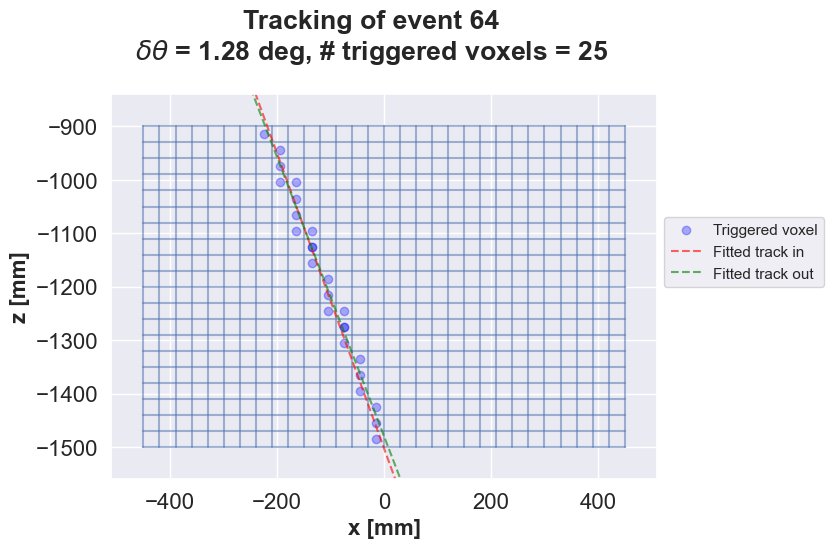

In [10]:
asr.plot_asr_event(
    event = event, # The event to plot 
    proj="XZ",  # The projection (either XZ or YZ) 
    )

## **III - Saving / loading triggered voxels**

The **triggered voxels** are automatically saved to a **hdf5 file**, in the `output_dir` folder.

In [11]:
from pathlib import Path
Path(output_dir + "triggered_voxels.hdf5").exists()

True

Such hdf5 file can be used to intitialize the `ASR` class. Given that finding the triggered voxels is rather computationally expensive, it can be usefull when imaging volumes with a large number of voxels.

In [12]:
asr = ASR(
    voi = voi, 
    tracking=mst, 
    output_dir=output_dir, 
    triggered_vox_file=output_dir+"triggered_voxels.hdf5")

../output_test directory created
Loading trigerred voxels from ../output_test/triggered_voxels.hdf5


In [13]:
asr

ASR algorithm using a collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

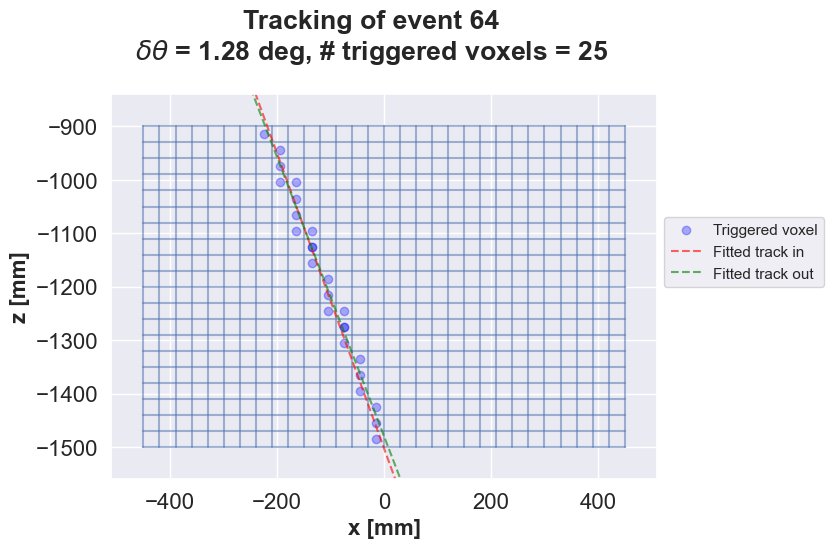

In [14]:
asr.plot_asr_event(
    event = event, # The event to plot 
    proj="XZ",  # The projection (either XZ or YZ) 
    figname= output_dir + "asr_event_display"
    )

## **IV - Predictions**


Similarly to `BCA.xyz_voxel_pred`, the ASR scattering density predictions `ASR.xyz_voxel_pred` is a  $(n_x, n_y, n_z)$ array of `floats`, where $n_i$ is the number of voxels along the $i$ direction.

In [15]:
asr.xyz_voxel_pred.size()


Assigning voxels score


Compute final score


torch.Size([30, 20, 20])

The reconstruction algorithm takes the following parameters as input:

 - `score_method`: Computes the **final** voxel's **score** $S_v$ as a function of the voxel's list $L_v$: $S_v = g(L_v)$, where $g$ is the `score_method`. By default, $g$ is the **median function**.

 - `p_range`: The range of muon momentum to consider, in MeV. Muons with momentum outside of `p_range` will be discarded. $[0, 10]$ TeV by default.

 - `dtheta_range`: The range of scattering angles to consider, in radiants. Muons with scattering angle outside of `p_range` will be discarded. $[0, \pi/3]$ rad by default.

 - `use_p`: Whether to use momentum data or not. `False` by default.

In [16]:
asr.asr_params

{'score_method': functools.partial(<function quantile at 0x79993c65d170>, q=0.5),
 'p_range': (0.0, 10000000),
 'dtheta_range': (0.0, 1.0471975511965976),
 'use_p': False}

Let's have a look at the predictions. 

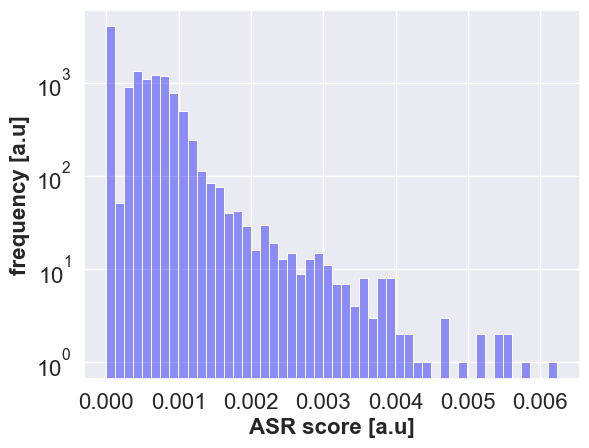

In [17]:
from muograph.plotting.plotting import plot_hist
plot_hist(asr.xyz_voxel_pred.ravel(), xlabel="ASR score [a.u]", logy=True, figname= output_dir + "asr_score")

Here are the **normalized predictions** computed as:

$$
pred_{norm} = \frac{pred - pred_{min}}{pred_{max} - pred_{min}}
$$


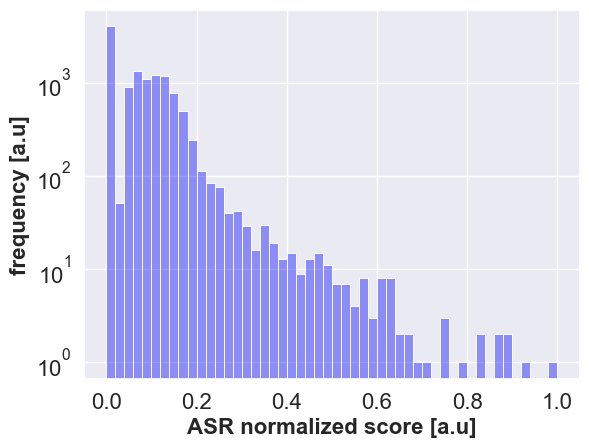

In [18]:
from muograph.plotting.plotting import plot_hist
plot_hist(asr.xyz_voxel_pred_norm.ravel(), xlabel="ASR normalized score [a.u]", logy=True)

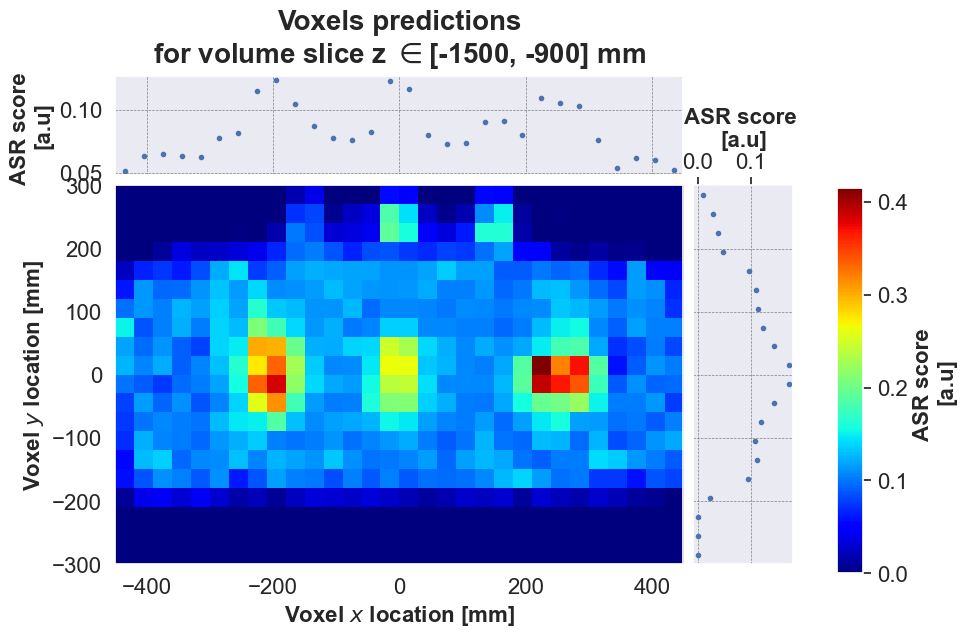

In [19]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_default_preds_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

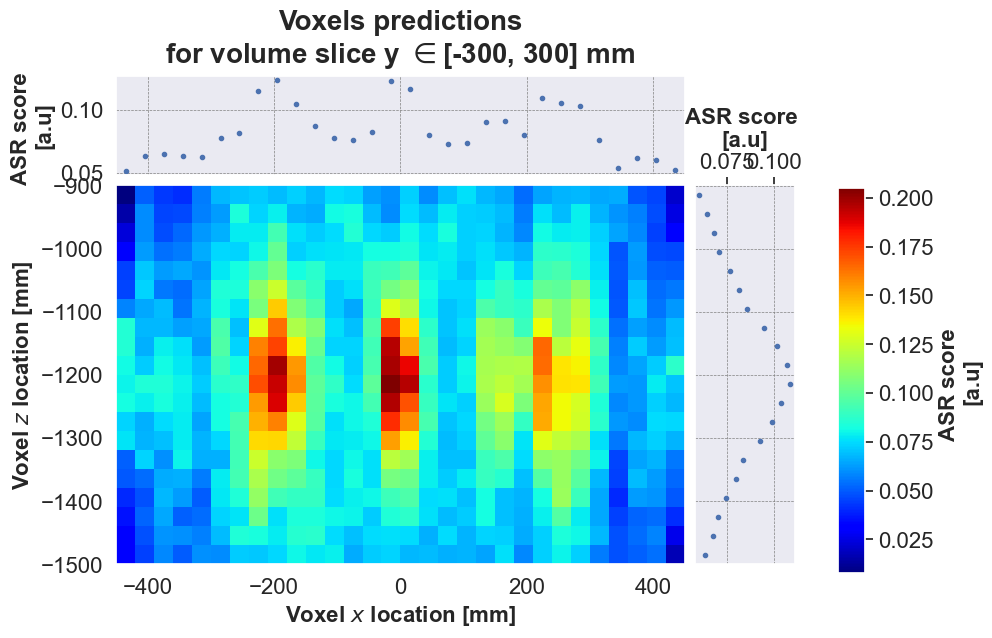

In [20]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 1

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_default_preds_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

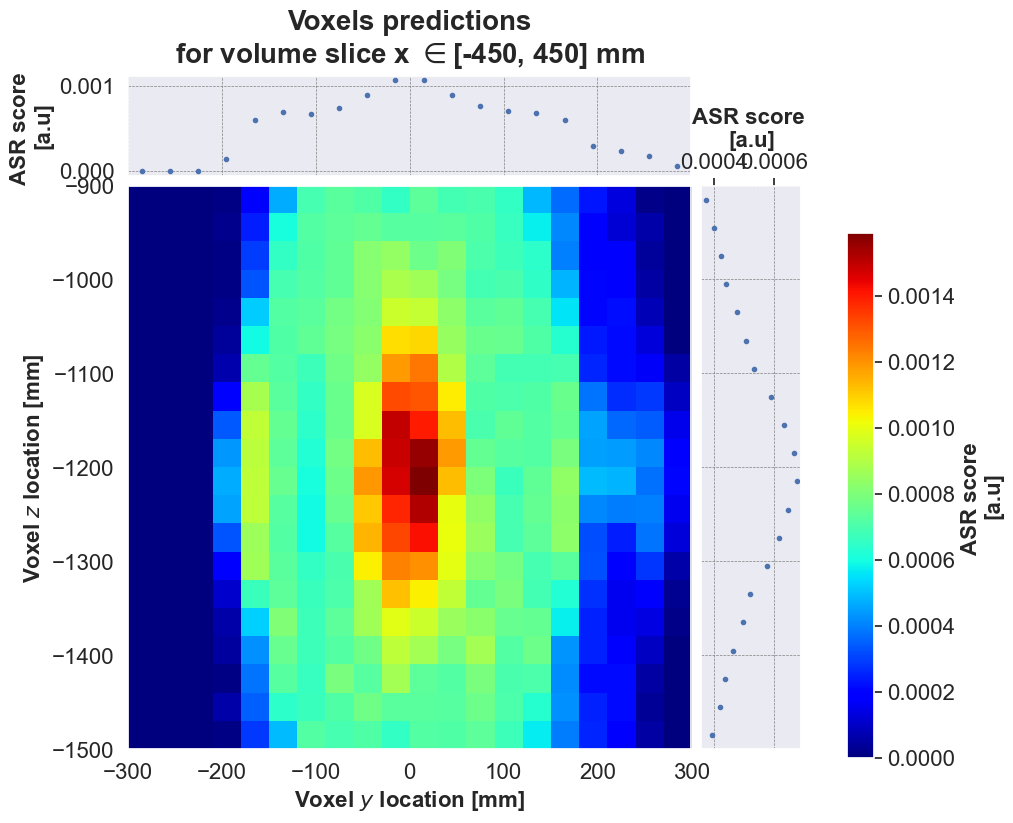

In [21]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 0

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_default_preds_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

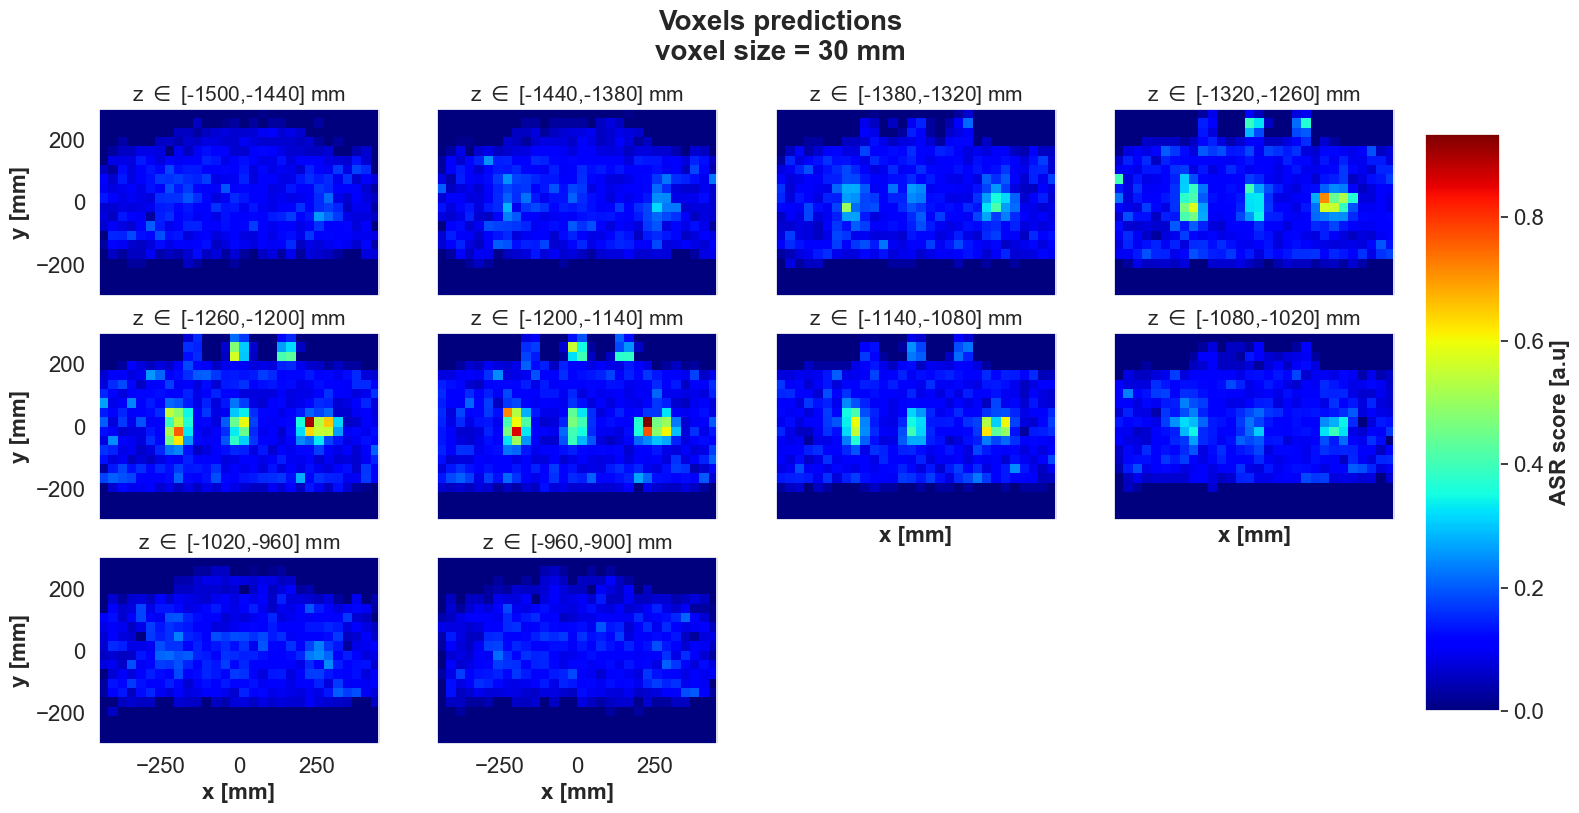

In [22]:
dim = 2

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_default_preds_slice"
)

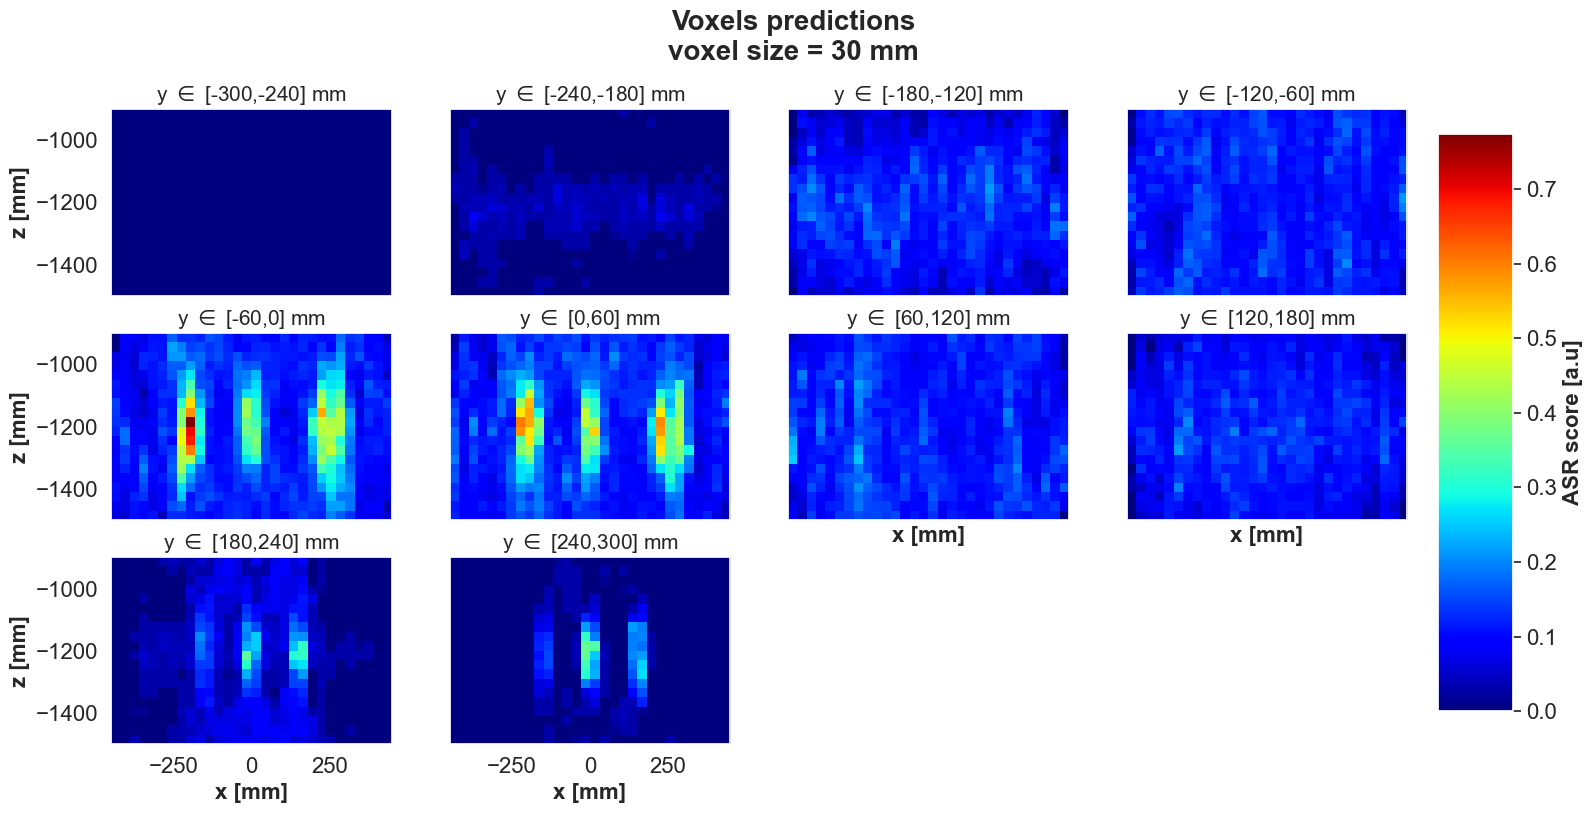

In [23]:
dim = 1

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_default_preds_slice"
)

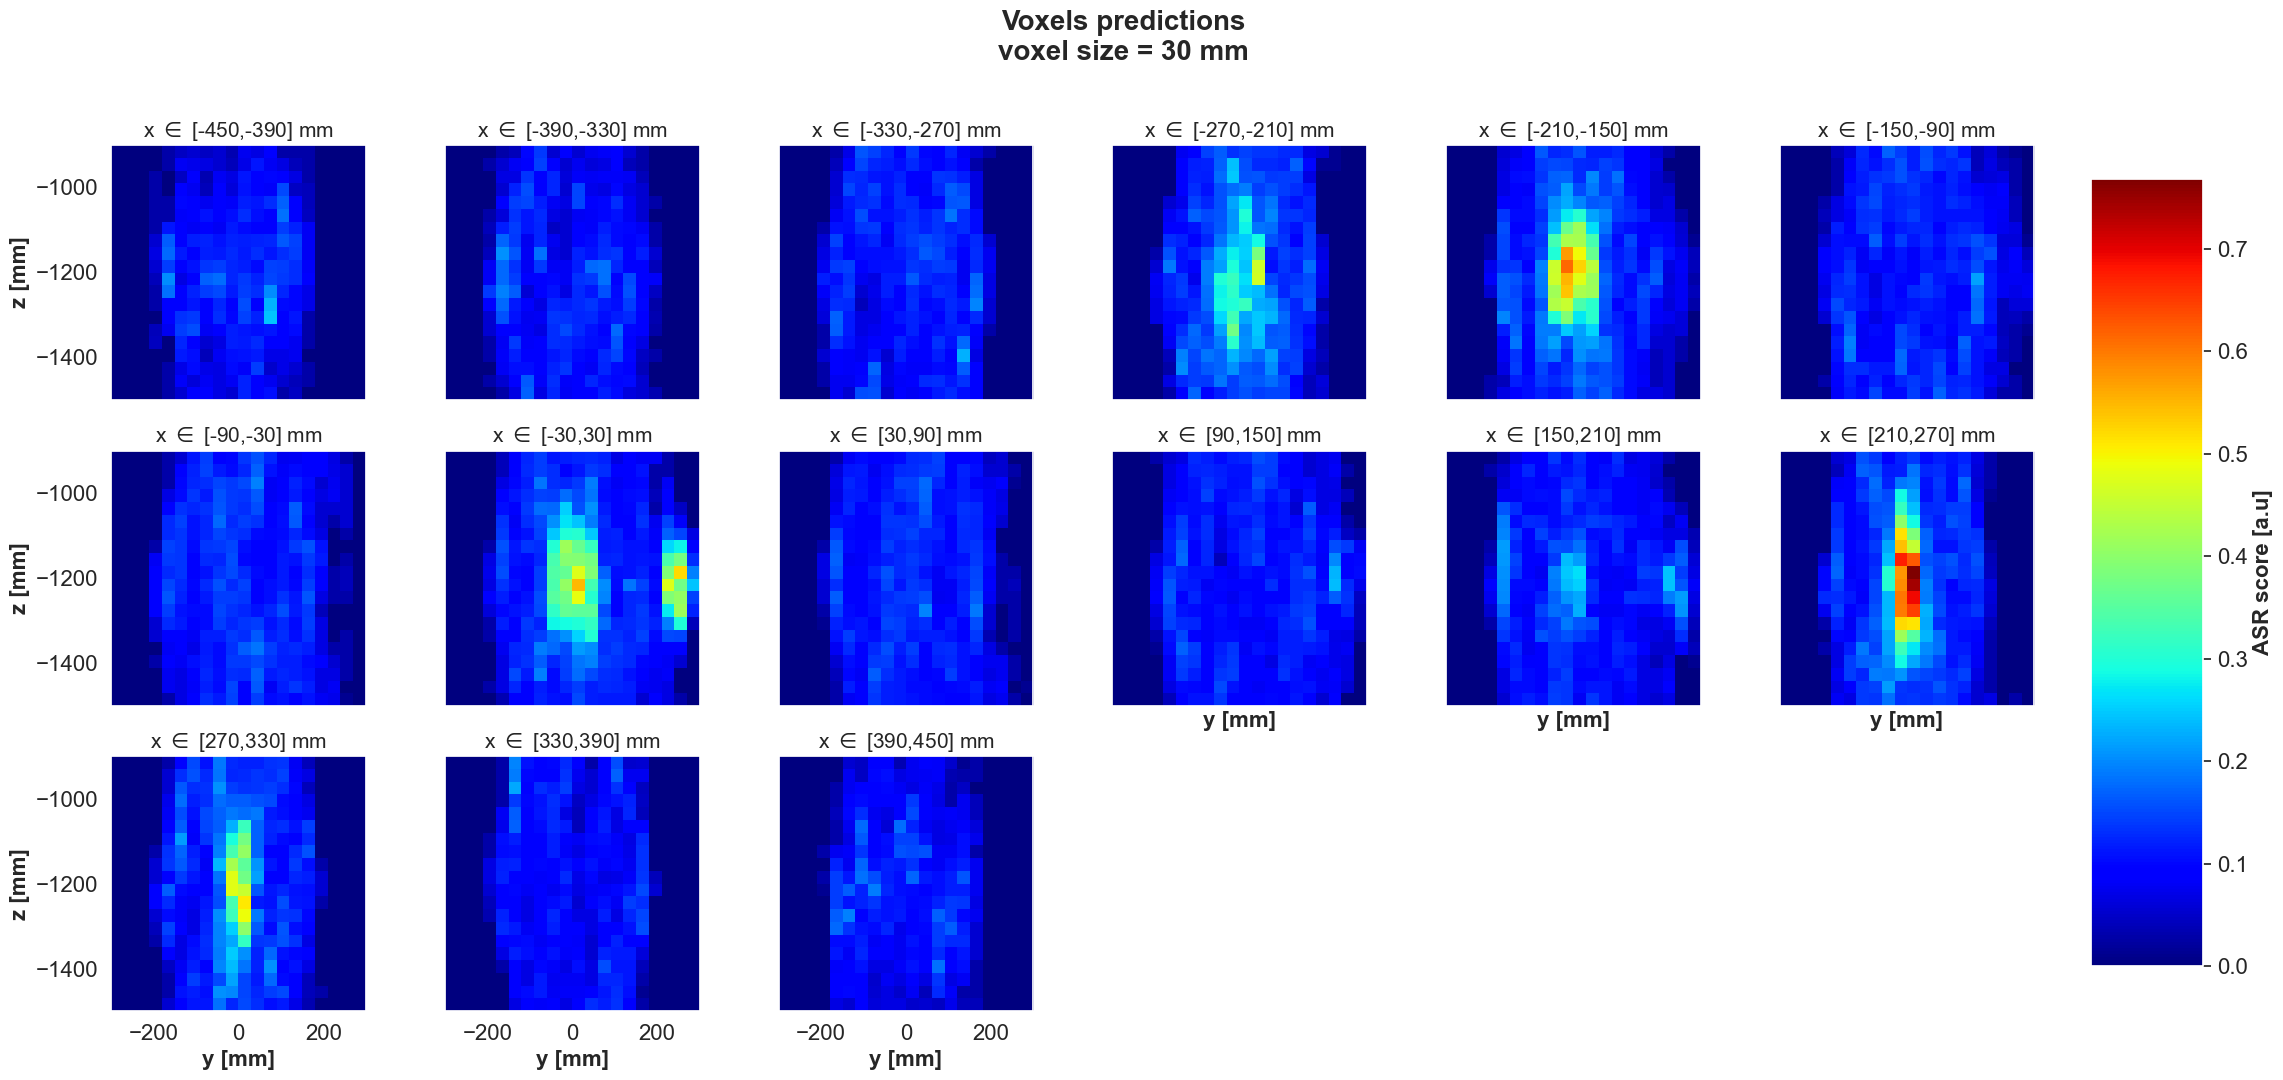

In [24]:
dim = 0

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=6, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_default_preds_slice"
)

Let's change the parameters of the algorithm and use momentum information:

In [25]:
import numpy as np
import math
from functools import partial
asr.asr_params = {
        "score_method": partial(np.quantile, q=0.5),
        "p_range": (0.0, 10000000),  # MeV
        "dtheta_range": (0.0, math.pi / 3),
        "use_p": True,
    }


Assigning voxels score


/home/geant/Desktop/muograph_public_release/muograph/tutorials/../muograph/reconstruction/asr.py:405: RuntimeWarning: divide by zero encountered in log
  score = np.log(self.tracks.dtheta.detach().cpu().numpy() * self.tracks.E.detach().cpu().numpy())


Compute final score


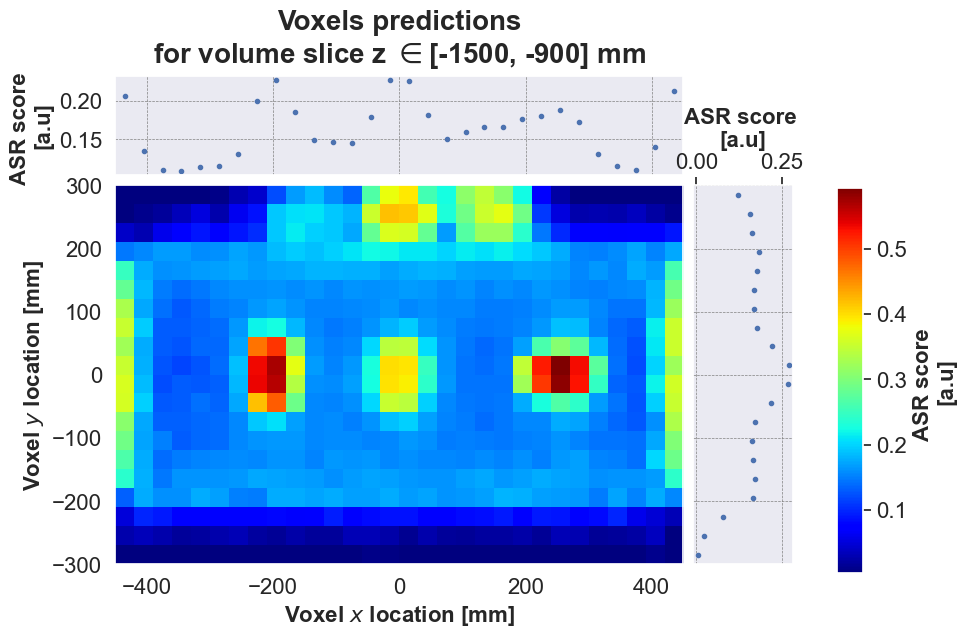

In [26]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_preds_use_p_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

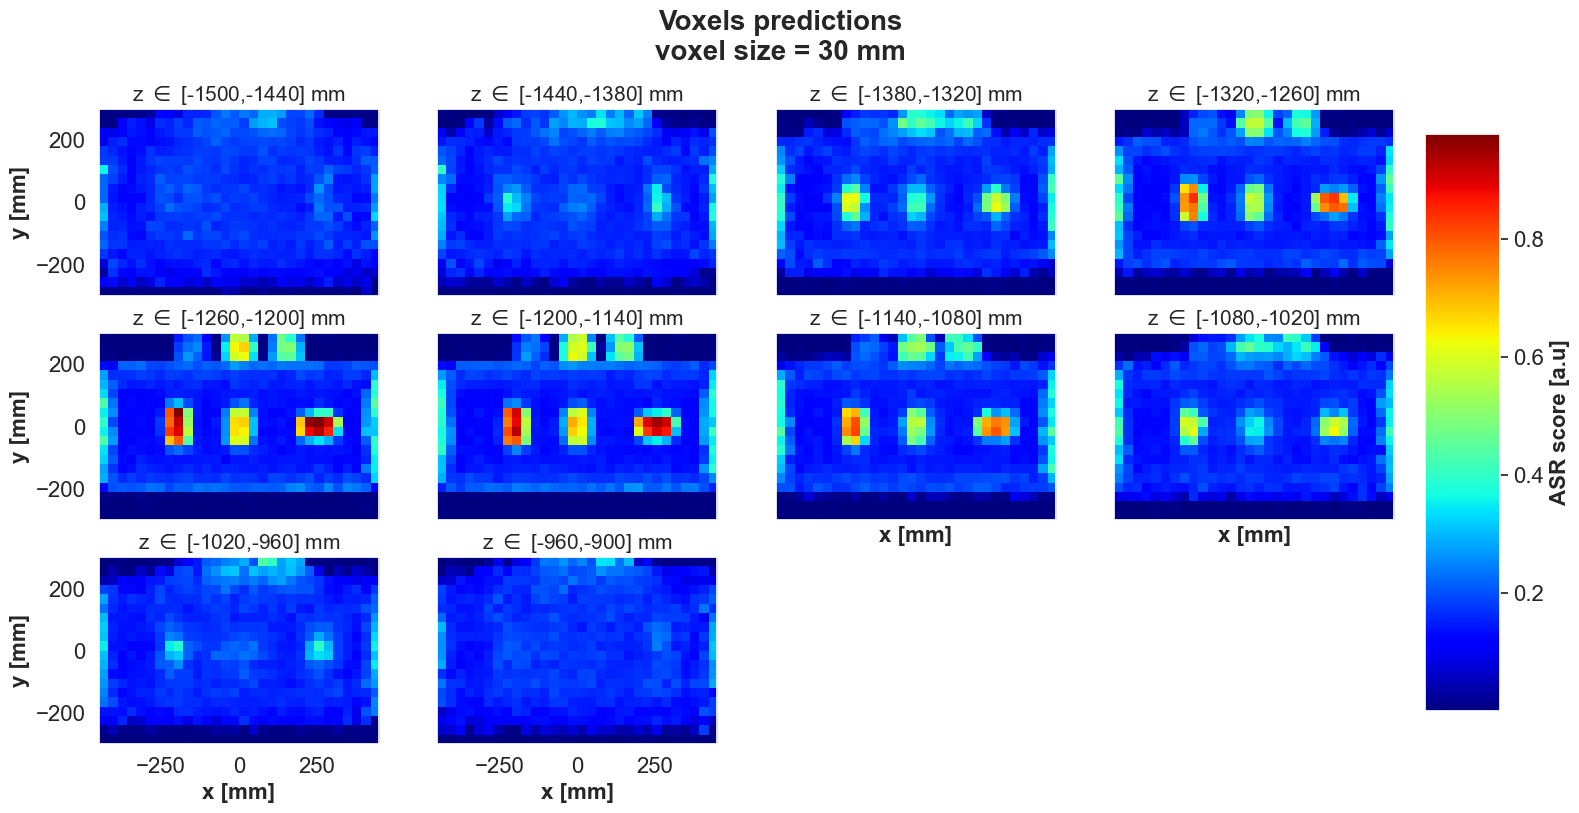

In [27]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_use_p_preds_slice"
)